# Volvo Construction Equipment Global(volvoce.com)
- 스크래핑 한 링크 : https://www.volvoce.com/global/en/news-and-events/press-releases/

## 셀레니움 설치
- WebDriverException: Message: Service chromedriver unexpectedly exited. Status code was: 1, -6 오류
- 해결 코드 복사해도 해결 안됨 => 블로그 코랩 사본 생성은 해결됨
- 코랩 코드 출처 : https://pgh268400.tistory.com/286

In [ ]:
# 이 부분은 처음 한번만 실행하면 됌.
# 코드 수정 - "The reason is that the last Ubuntu update update supports chromium driver just via snap."
# 최근 우분투 업데이트에서 크롬 드라이버 설치를 snap을 이용해서만 하도록 바뀜
# 고로 snap 없이 설치하는 아래 우회 코드로 변경
# 출처 : https://colab.research.google.com/drive/1cbEvuZOhkouYLda3RqiwtbM-o9hxGLyC
# 출처2 : https://stackoverflow.com/questions/75155063/selenium-use-chrome-on-colab-got-unexpectedly-exited

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.f7k7v6JIzz/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.UoTMbZHlU5/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.J5cxeyxAQ9/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Hit:2 http://archive.ubuntu.com/ubuntu 

In [ ]:
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
# 아직 BeautifulSoup은 사용하지 않아서 나중에 삭제 할 예정
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

import pandas as pd

## 웹 드라이버 설정 및 객체 생성



In [ ]:
#Colab에선 웹브라우저 창이 뜨지 않으므로 별도 설정한다.
 
options = webdriver.ChromeOptions()
options.add_argument('--headless')        # Head-less 설정
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# 웹 드라이버 객체 생성
driver = webdriver.Chrome('chromedriver', options=options)

## 뉴스 페이지 목록 스크래핑 연습
- 각 뉴스를 클릭 > 뉴스 스크래핑 하기 전, 한 페이지 내 기사 목록들이 잘 스크래핑 되는지 확인

### newslists_scraping() : 뉴스리스트 스크래핑 함수
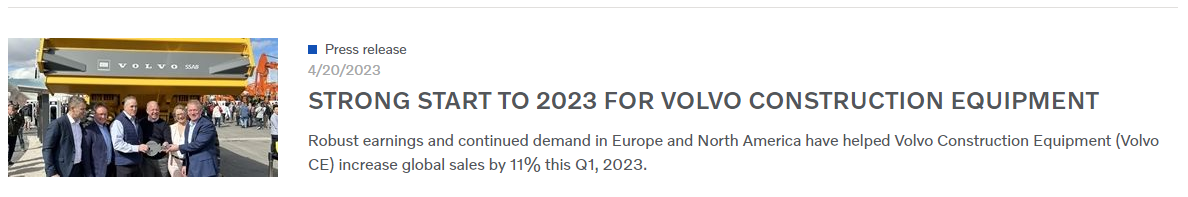

- 해당 박스가 속한 CLASS_NAME : newsList
- Press release의 CLASS_NAME : news-item-category
- 날짜 CLASS_NAME : news-item-date
- 제목 CLASS_NAME : news-item-title
- 기사 본문 요약 CLASS_NAME : news-item-excerpt

In [ ]:
def newslists_scraping(newslists_url, driver):
  print('[뉴스 리스트 스크래핑]') # 스크래핑이 실행되는지 확인하기 위해 print()로 스크래핑 문구 출력
  newslists_idx = 0 # 한 페이지 기사는 20개가 있음. 인덱스 값은 0~19까지 나올 예정
  newslists = driver.find_elements(By.CLASS_NAME, 'newsList')
  newslists_df = pd.DataFrame(columns = ("category", "datetime", "title", "summary"))
  
  # 페이지 내 전체 리스트를 출력하기 위해 반복문
  for newslist in newslists:
    category = newslist.find_element(By.CLASS_NAME, 'news-item-category').text
    datetime = newslist.find_element(By.CLASS_NAME, 'news-item-date').text
    title = newslist.find_element(By.CLASS_NAME, 'news-item-title').text
    summary = newslist.find_element(By.CLASS_NAME, 'news-item-excerpt').text
    print(f"뉴스 #{newslists_idx+1}:", [category, datetime, title, summary]) # 뉴스 넘버1부터 시작할 수 있도록 idx+1을 해줌
    newslists_df.loc[newslists_idx] = [category, datetime, title, summary]
    newslists_idx += 1

  return newslists_df

### scraping() : 스크래핑 함수

In [ ]:
def scraping():
  driver = webdriver.Chrome('chromedriver', options=options)

  # 사이트 접속
  newslists_url = "https://www.volvoce.com/global/en/news-and-events/press-releases/"
  driver.get(newslists_url)
  
  # 뉴스리스트 스크래핑 함수를 불러옴
  newslists_df = newslists_scraping(newslists_url, driver)

  driver.close()

  return newslists_df

In [ ]:
# 스크래핑 콜
newslists_df = scraping()

[뉴스 리스트 스크래핑]
뉴스 #1: ['Press release', '4/20/2023', 'STRONG START TO 2023 FOR VOLVO CONSTRUCTION EQUIPMENT', 'Robust earnings and continued demand in Europe and North America have helped Volvo Construction Equipment (Volvo CE) increase global sales by 11% this Q1, 2023.']
뉴스 #2: ['Press release', '3/23/2023', 'KAMEL SID APPOINTED HEAD OF OPERATIONS AT VOLVO CONSTRUCTION EQUIPMENT', 'Volvo Construction Equipment (Volvo CE) has announced that Kamel Sid has been appointed Head of Operations.']
뉴스 #3: ['Press release', '3/15/2023', 'VOLVO CONSTRUCTION EQUIPMENT HIGHLIGHTS COMPLETE SOLUTIONS FOR A CHANGING INDUSTRY WITH IMMERSIVE EXPERIENCE AT CONEXPO-CON/AGG', 'Volvo Construction Equipment (Volvo CE) showcased the present and future of the construction industry at CONEXPO-CON/AGG with machines and services that offer customers solutions to enhance...']
뉴스 #4: ['Press release', '3/15/2023', 'VOLVO CONSTRUCTION EQUIPMENT HELPS CUSTOMERS SEE BIGGER PICTURE WITH CONNECTED MAP IN NORTH AMERICA'

In [ ]:
newslists_df

,category,datetime,title,summary
0,Press release,4/20/2023,STRONG START TO 2023 FOR VOLVO CONSTRUCTION EQ...,Robust earnings and continued demand in Europe...
1,Press release,3/23/2023,KAMEL SID APPOINTED HEAD OF OPERATIONS AT VOLV...,Volvo Construction Equipment (Volvo CE) has an...
2,Press release,3/15/2023,VOLVO CONSTRUCTION EQUIPMENT HIGHLIGHTS COMPLE...,Volvo Construction Equipment (Volvo CE) showca...
3,Press release,3/15/2023,VOLVO CONSTRUCTION EQUIPMENT HELPS CUSTOMERS S...,Volvo Construction Equipment (Volvo CE) at CON...
4,Press release,3/15/2023,VOLVO CE DELIVERS NORTH AMERICA’S FIRST MACHIN...,"Today at CONEXPO 2023 in Las Vegas, Volvo Cons..."
5,Press release,3/15/2023,VOLVO CONSTRUCTION EQUIPMENT OPENS PRE-ORDER T...,Volvo Construction Equipment (Volvo CE) announ...
6,Press release,3/15/2023,VOLVO CE LAUNCHES THREE COMPACT ASSIST PACKAGE...,Two entry-level packages for Volvo Constructio...
7,Press release,3/15/2023,VOLVO REMOTE CONTROL EXCAVATORS PUT SAFETY AND...,An advanced Short Range Remote Control solutio...
8,Press release,3/15/2023,VOLVO CONSTRUCTION EQUIPMENT INTRODUCES CONNEC...,Managing the load out process at a busy site c...
9,Press release,3/15/2023,VOLVO CONSTRUCTION EQUIPMENT LAUNCHES TASK MAN...,Managing a busy worksite can be time consuming...


## 다음 페이지 클릭 연습
- 2페이지 기사 목록을 스크래핑 한다는 표시 "[>]"와 23년 1월 11일자로 시작하는 2페이지 기사 목록이 출력이 됨
- 문제 상황 : 1페이지 기사 목록 출력 > 다음 페이지 클릭 > 2페이지 출력 > 다음 페이지 클릭 과 같은 과정을 반복하기를 원했으나, 반복문 수정이 필요해보임.
- 목요일까지 목표
  - '기사 목록들 1~29 페이지까지' 반복 출력
  - '기사를 클릭 > 기사 본문 스크래핑 > 나와서 그 다음 기사 클릭' 반복 구현


In [ ]:
def newslists_scraping(newslists_url, driver):
  # 다음 페이지를 클릭할 수 있도록 반복문
  try:
    while True:
      # 2페이지 <a> 태그의 클래스 네임 "next"
      # 2페에지 <a> 태그의 CSS selector 경로 : body > div.container > div > a.next
      # 1페이지 <a> 태그의 클래스 네임 "next"
      # 1페이지 <a> 태그의 CSS selector 경로 : body > div.container > div > a
      driver.find_element(By.CSS_SELECTOR, 'body > div.container > div > a').click()
      print("[>]", end="") # 제대로 되었는지 확인해보기 위해서 다음 페이지가 클릭이 되면 ">"를 출력하도록 print()
      time.sleep(1)
  except:
    pass

  print('[뉴스 리스트 스크래핑]')
  newslists_idx = 0
  newslists = driver.find_elements(By.CLASS_NAME, 'newsList')
  newslists_df = pd.DataFrame(columns = ("category", "datetime", "title", "summary"))

  for newslist in newslists:
    category = newslist.find_element(By.CLASS_NAME, 'news-item-category').text
    datetime = newslist.find_element(By.CLASS_NAME, 'news-item-date').text
    title = newslist.find_element(By.CLASS_NAME, 'news-item-title').text
    summary = newslist.find_element(By.CLASS_NAME, 'news-item-excerpt').text
    print(f"뉴스 #{newslists_idx+1}:", [category, datetime, title, summary])
    newslists_df.loc[newslists_idx] = [category, datetime, title, summary]
    newslists_idx += 1

  return newslists_df

In [ ]:
def scraping():
  driver = webdriver.Chrome('chromedriver', options=options)

  # 사이트 접속
  newslists_url = "https://www.volvoce.com/global/en/news-and-events/press-releases/"
  driver.get(newslists_url)
  
  # 댓글 수집 함수
  newslists_df = newslists_scraping(newslists_url, driver)

  driver.close()

  return newslists_df

In [ ]:
# 스크래핑 콜
newslists_df = scraping()

[>][뉴스 리스트 스크래핑]
뉴스 #1: ['Press release', '1/11/2023', 'VOLVO CE INTRODUCES COLLISION MITIGATION SYSTEM FOR JOBSITE SAFETY', 'Delivering on its vision for zero accidents, Volvo Construction Equipment (Volvo CE) launches its Collision Mitigation System for Volvo Wheel Loaders – an automatic braking feature that...']
뉴스 #2: ['Press release', '11/24/2022', "VOLVO CE PARTNERS ON SWEDEN'S LARGEST FOSSIL FREE WORKSITE", 'More than 2,000 tons of CO2 will be saved in a partnership to transform a 100-year-old meat-packing district in the center of Stockholm, Sweden, setting a new benchmark for almost entirely...']
뉴스 #3: ['Press release', '11/9/2022', 'EMISSION-FREE RECYCLING IN BAVARIA WITH ELECTRIC MACHINES FROM VOLVO CE', 'German recycling firm, Böhm Entsorgung, is using electric machines from Volvo Construction Equipment (Volvo CE)']
뉴스 #4: ['Press release', '11/2/2022', 'VOLVO CE CONTINUES INDUSTRY TRANSFORMATION WITH INVESTMENT TOWARDS ELECTRIC HAULING SOLUTIONS', 'Volvo Construction Equi

In [ ]:
newslists_df

,category,datetime,title,summary
0,Press release,1/11/2023,VOLVO CE INTRODUCES COLLISION MITIGATION SYSTE...,"Delivering on its vision for zero accidents, V..."
1,Press release,11/24/2022,VOLVO CE PARTNERS ON SWEDEN'S LARGEST FOSSIL F...,"More than 2,000 tons of CO2 will be saved in a..."
2,Press release,11/9/2022,EMISSION-FREE RECYCLING IN BAVARIA WITH ELECTR...,"German recycling firm, Böhm Entsorgung, is usi..."
3,Press release,11/2/2022,VOLVO CE CONTINUES INDUSTRY TRANSFORMATION WIT...,Volvo Construction Equipment (Volvo CE) is inv...
4,Press release,10/20/2022,VOLVO CE ACHIEVES GOOD PROFITABILITY IN Q3 2022,Solid demand in most regions has resulted in a...
5,Press release,10/5/2022,VOLVO CE HELPS ELEVATE MOTORSPORT SAFETY WITH ...,The patent-pending tool co-developed by Volvo ...
6,Press release,9/5/2022,VOLVO CE PARTNERS WITH BRIO TO INSPIRE BUDDING...,Volvo Construction Equipment (Volvo CE) and fa...
7,Press release,8/12/2022,FIA WORLD RX ELECTRIC ERA TAKES OFF WITH VOLVO...,Volvo Construction Equipment (Volvo CE) provid...
8,Press release,7/19/2022,"VOLVO CE REMAINS STRONG IN Q2, 2022",Moderate fluctuations across different regions...
9,Press release,7/15/2022,PIONEERING PARTNERSHIP STRIVES FOR NET ZERO CO...,A pioneering partnership between Volvo Constru...


## 뉴스 기사 본문 스크래핑

In [ ]:
def news_scraping(news_url, driver):

  # category = driver.find_element(By.XPATH, '/html/body/div[1]/div[1]/div/div/div[1]/span[1]').text
  title = driver.find_element(By.CSS_SELECTOR, 'body > div.container > div.newsIntro > div > div > div.news-article-headline > h1').text
  datetime = driver.find_element(By.CSS_SELECTOR, 'body > div.container > div.newsIntro > div > div > div.news-article-headline > span.news-article-date').text
  author = driver.find_element(By.CSS_SELECTOR, 'body > div.container > div.newsIntro > div > div > div.news-article-headline > span.news-article-author').text
  summary = driver.find_element(By.CSS_SELECTOR, 'body > div.container > div.newsIntro > div > div > p').text
  # image_caption = driver.find_element(By.CLASS_NAME, 'image-caption').text
  article = driver.find_element(By.CSS_SELECTOR, 'body > div.container > div.newsArticle').text

  print("뉴스:", [title, datetime, author, summary, article, news_url])

  return [title, datetime, author, summary, article, news_url]

In [ ]:
def scraping():
  driver = webdriver.Chrome('chromedriver', options=options)
  
  news_idx = 0
  news_df = pd.DataFrame(columns = ("title", "datetime", "author", "summary", "article", "url"))

  news_url = 'https://www.volvoce.com/global/en/news-and-events/press-releases/2023/strong-start-to-2023-for-volvo-construction-equipment/'
  driver.get(news_url)

  news_df.loc[news_idx] = news_scraping(news_url, driver)
  news_idx += 1

  driver.close()
  
  return news_df

In [ ]:
# 스크래핑 콜
news_df = scraping()

뉴스: ['STRONG START TO 2023 FOR VOLVO CONSTRUCTION EQUIPMENT', '4/20/2023', 'By Press information', 'Robust earnings and continued demand in Europe and North America have helped Volvo Construction Equipment (Volvo CE) increase global sales by 11% this Q1, 2023.', 'In Q1, 2023, Volvo CE has secured good profitability and a boost to its operating margin with continued demand in large infrastructure and construction projects – particularly in North America and Europe – while increasing its own investments into the biggest technological shift in the industry’s history. \n\nCompared to the same period last year, Volvo CE is reporting a strong boost in sales of 17% in Europe and 37% in North America. This is more than compensating for a dip in sales in Asia and South America where investment levels have slowed down. With the exception of China, activity in the construction industry has continued to be good across most markets, driven primarily by ongoing infrastructure investments and by the 

In [ ]:
news_df

,title,datetime,author,summary,article,url
0,STRONG START TO 2023 FOR VOLVO CONSTRUCTION EQ...,4/20/2023,By Press information,Robust earnings and continued demand in Europe...,"In Q1, 2023, Volvo CE has secured good profita...",https://www.volvoce.com/global/en/news-and-eve...
